In [1]:
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'train',
    labels = 'inferred',
    label_mode = 'binary',
    batch_size = 32,
    image_size=(224, 224)
)

Found 5218 files belonging to 2 classes.


In [3]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'test',
    labels = 'inferred',
    label_mode = 'binary',
    batch_size = 32,
    image_size=(224, 224)
)


Found 624 files belonging to 2 classes.


In [4]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'val',
    labels = 'inferred',
    label_mode = 'binary',
    batch_size = 32,
    image_size=(224, 224)
)


Found 16 files belonging to 2 classes.


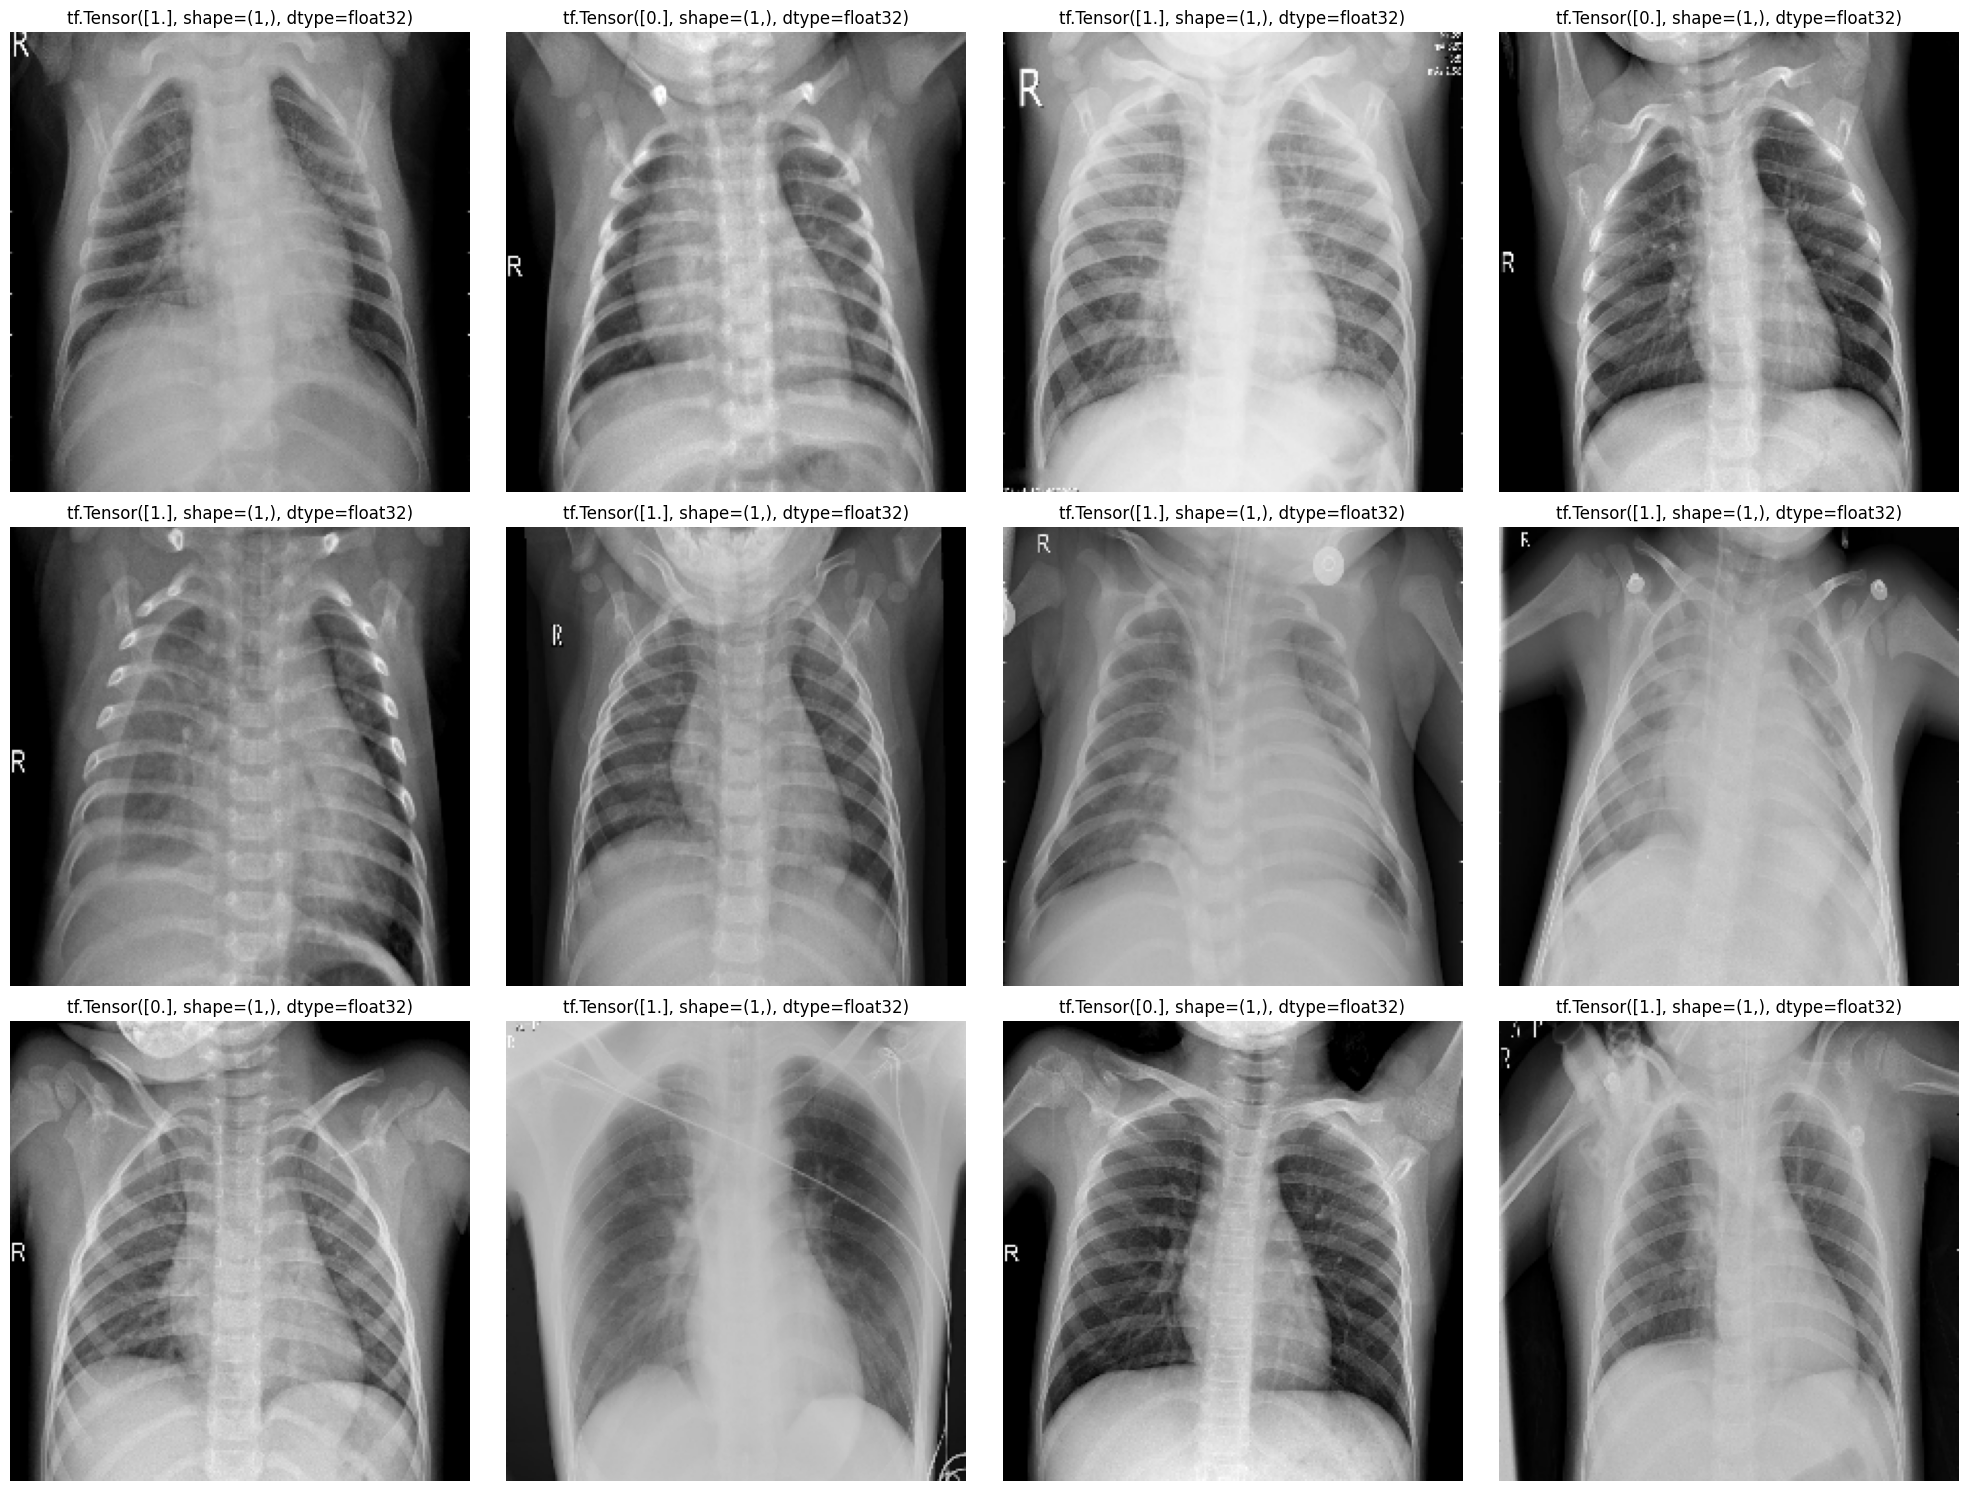

In [5]:
plt.figure(figsize=(20, 15))

for images, labels in train_ds.take(1): 
    for i in range(12): 
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i])
        plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
labels_list_train = []

for images, labels in train_ds.unbatch():
    labels_list_train.append(int(labels.numpy().squeeze()))


unique, counts = np.unique(labels_list_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

Class Distribution: {np.int64(0): np.int64(1343), np.int64(1): np.int64(3875)}


Class Distribution: {np.int64(0): np.int64(1343), np.int64(1): np.int64(3875)}


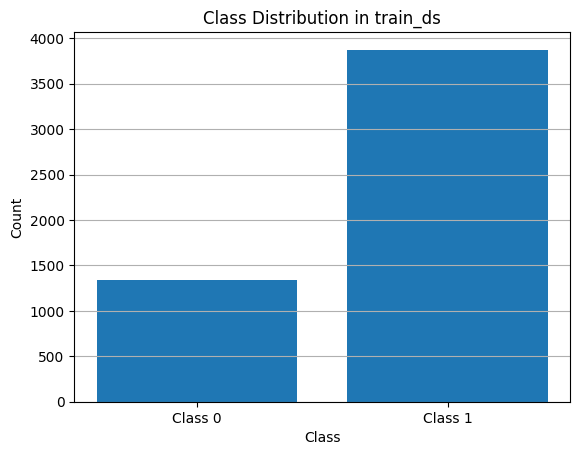

In [7]:
labels_list_train = []

for images, labels in train_ds.unbatch():
    labels_list_train.append(int(labels.numpy().squeeze()))

unique, counts = np.unique(labels_list_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

plt.bar(class_distribution.keys(), class_distribution.values(), tick_label=[f"Class {k}" for k in class_distribution.keys()])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in train_ds")
plt.grid(axis='y')
plt.show()

Class Distribution: {np.int64(0): np.int64(234), np.int64(1): np.int64(390)}


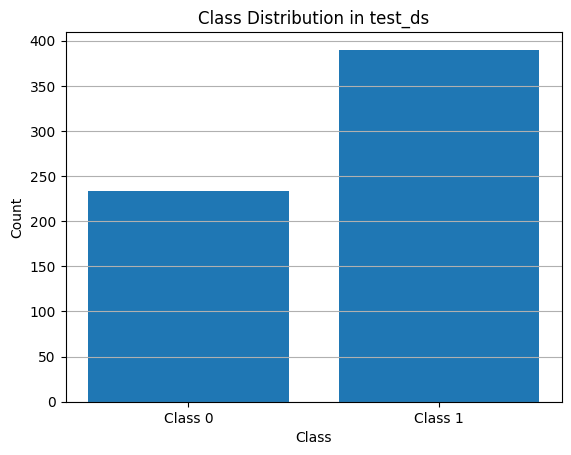

In [8]:
labels_list_test = []

for images, labels in test_ds.unbatch():
    labels_list_test.append(int(labels.numpy().squeeze()))

unique, counts = np.unique(labels_list_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

plt.bar(class_distribution.keys(), class_distribution.values(), tick_label=[f"Class {k}" for k in class_distribution.keys()])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in test_ds")
plt.grid(axis='y')
plt.show()

Class Distribution: {np.int64(0): np.int64(234), np.int64(1): np.int64(390)}


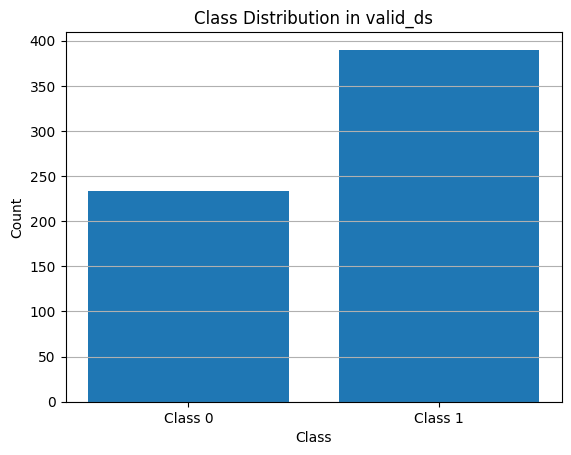

In [9]:
labels_list_valid = []

for images, labels in test_ds.unbatch():
    labels_list_valid.append(int(labels.numpy().squeeze()))

unique, counts = np.unique(labels_list_valid, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

plt.bar(class_distribution.keys(), class_distribution.values(), tick_label=[f"Class {k}" for k in class_distribution.keys()])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in valid_ds")
plt.grid(axis='y')
plt.show()

In [10]:
for i, class_name in enumerate(train_ds.class_names):
    print(f"Label {i} -> Class '{class_name}'")

Label 0 -> Class 'NORMAL'
Label 1 -> Class 'PNEUMONIA'


In [11]:
for i, class_name in enumerate(test_ds.class_names):
    print(f"Label {i} -> Class '{class_name}'")

Label 0 -> Class 'NORMAL'
Label 1 -> Class 'PNEUMONIA'


In [12]:
for i, class_name in enumerate(valid_ds.class_names):
    print(f"Label {i} -> Class '{class_name}'")

Label 0 -> Class 'NORMAL'
Label 1 -> Class 'PNEUMONIA'


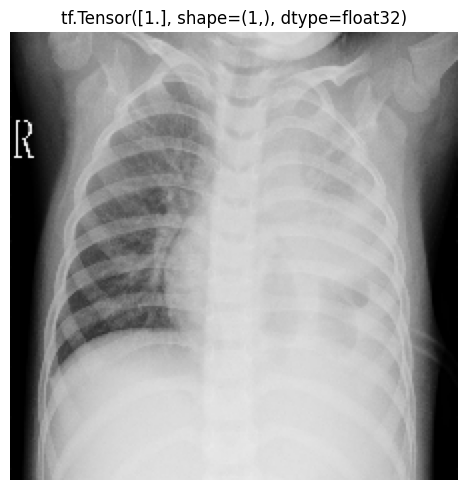

In [13]:
plt.figure(figsize=(5, 5))

for images, labels in train_ds: 
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(labels[0])
        plt.axis("off")

plt.tight_layout()
plt.show()

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


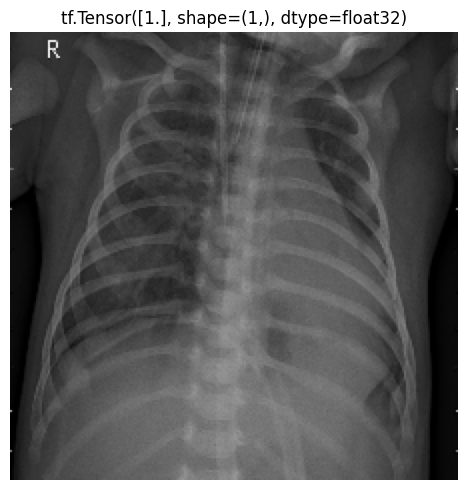

In [14]:
plt.figure(figsize=(5, 5))

for images, labels in test_ds: 
        plt.imshow(images[1].numpy().astype("uint8"))
        plt.title(labels[1])
        plt.axis("off")
        print(images[1].shape)

plt.tight_layout()
plt.show()

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
])

In [16]:
neg = len(tf.io.gfile.glob('train/NORMAL/*'))
pos = len(tf.io.gfile.glob('train/PNEUMONIA/*'))
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0 (Normal): {weight_for_0:.2f}')
print(f'Weight for class 1 (Pneumonia): {weight_for_1:.2f}')

Weight for class 0 (Normal): 1.94
Weight for class 1 (Pneumonia): 0.67


In [17]:
def process (image,label):
    image = tf.cast(image/255.,tf.float32)
    return image,label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [18]:
inputs = Input(shape=(224, 224, 3))

resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

resnet.trainable = False

x = data_augmentation(inputs)
x = resnet(x, training= False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x) 
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,kernel_regularizer=keras.regularizers.l2(0.001), activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

resnet.trainable = True
for layer in resnet.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,718,913 (90.48 MB)

 Trainable params: 17,081,729 (65.16 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [19]:
checkpoint = ModelCheckpoint('best_medical_classifier.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [20]:
model.fit(train_ds,batch_size=32, epochs=20, validation_data=test_ds,class_weight=class_weight, callbacks=[checkpoint, early_stopping, lr_scheduler] )

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.7088 - loss: 0.5595 - val_accuracy: 0.6811 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.8071 - loss: 0.4025 - val_accuracy: 0.7692 - val_loss: 0.5437 - learning_rate: 1.0000e-04
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8122 - loss: 0.3819 - val_accuracy: 0.6474 - val_loss: 2.1153 - learning_rate: 1.0000e-04
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.8303 - loss: 0.3631 - val_accuracy: 0.7885 - val_loss: 0.4607 - learning_rate: 1.0000e-04
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.8106 - loss: 0.3976 - val_accuracy: 0.6250 - val_loss: 8.1761 - learning_rate: 1.0000e-04
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.8324 - loss: 0.3631 - val_accuracy: 0.8029 - val_loss: 0.4019 - learning_rate: 1.0000e-04
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - acc

In [21]:
model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8824 - loss: 0.3044


[0.30929574370384216, 0.8782051205635071]

In [22]:
model.evaluate(train_ds)

164/164 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.8842 - loss: 0.2724


[0.2549438178539276, 0.8945956230163574]

In [23]:
model.evaluate(valid_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - accuracy: 0.5000 - loss: 0.7774


[0.7773736119270325, 0.5]

In [24]:
model.history.history

{'accuracy': [0.7656190395355225,
  0.814871609210968,
  0.8160214424133301,
  0.8319279551506042,
  0.8282867074012756,
  0.8422767519950867,
  0.8499425053596497,
  0.8541586995124817,
  0.8620160818099976,
  0.8679570555686951,
  0.865848958492279,
  0.8694902062416077,
  0.8836718797683716,
  0.8783058524131775,
  0.8773476481437683,
  0.882138729095459,
  0.8825220465660095,
  0.8865465521812439,
  0.886354923248291,
  0.8855883479118347],
 'loss': [0.4821961224079132,
  0.3961775302886963,
  0.3836570084095001,
  0.3607197403907776,
  0.3685300946235657,
  0.34956151247024536,
  0.3363356292247772,
  0.3243609368801117,
  0.3214958906173706,
  0.29747849702835083,
  0.3025524914264679,
  0.2883037030696869,
  0.26675477623939514,
  0.28495728969573975,
  0.27666470408439636,
  0.27583780884742737,
  0.26462307572364807,
  0.27093076705932617,
  0.27219313383102417,
  0.2704285681247711],
 'val_accuracy': [0.6810897588729858,
  0.7692307829856873,
  0.6474359035491943,
  0.7884615

In [25]:
model.history.history['accuracy']

[0.7656190395355225,
 0.814871609210968,
 0.8160214424133301,
 0.8319279551506042,
 0.8282867074012756,
 0.8422767519950867,
 0.8499425053596497,
 0.8541586995124817,
 0.8620160818099976,
 0.8679570555686951,
 0.865848958492279,
 0.8694902062416077,
 0.8836718797683716,
 0.8783058524131775,
 0.8773476481437683,
 0.882138729095459,
 0.8825220465660095,
 0.8865465521812439,
 0.886354923248291,
 0.8855883479118347]

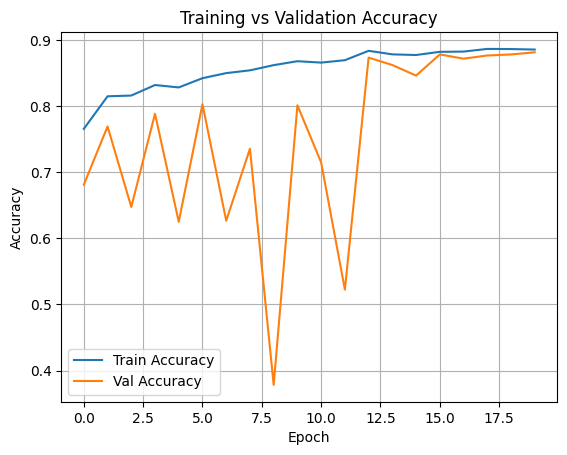

In [26]:
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

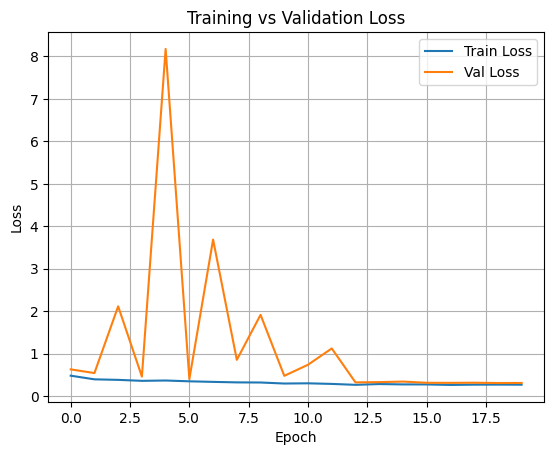

In [27]:
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true).flatten()

y_pred_probs = model.predict(test_ds)

y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(y_pred)

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal (0)', 'Pneumonia (1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
[1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1
 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1
 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1
 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0
 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 

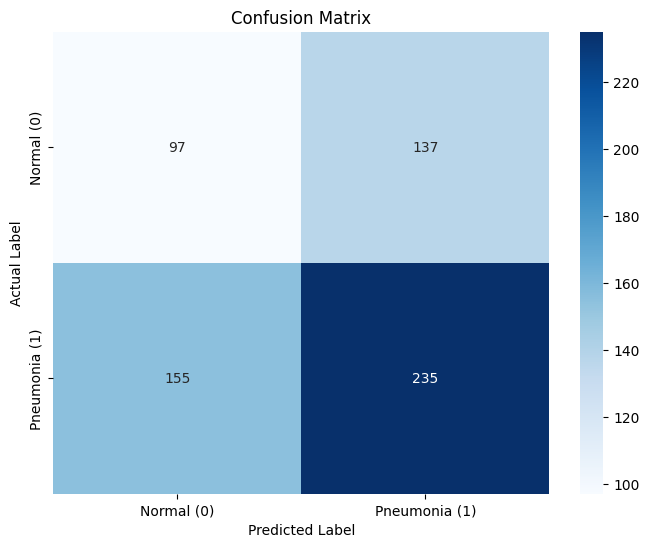

In [29]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Pneumonia (1)'],
            yticklabels=['Normal (0)', 'Pneumonia (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()